## Name: Joshua Wacks<br />Student Number: 2143116<br />Project Choice: Project 1 – Spam Classification Using Naïve Baye

In [1]:
import warnings
warnings.filterwarnings("ignore")

!pip install PrettyTable --quiet
# !pip install seaborn
# !pip install collections
!pip install sklearn

In [2]:

#important library to organise output

import pandas as pd
import string
import re
from nltk.corpus import stopwords
import numpy as np
from collections import Counter
import sklearn
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Preprocess the data, tokenize the text, and get a list of words for each sentence. [10 marks]

In [3]:
stopwords_english = stopwords.words('english')

In [4]:
# with open('currencies.txt',encoding="utf8") as file:
# 	print(file.read().splitlines())

TODO Take a look at stemming or lemming the words or just using NLTK preprocessing

TODO Implement technique to not take out currencies for improved model

In [5]:
def preprocess_data(table):
	#We remove all \r,\n tokens from the string
	table['text'] = table.text.apply(lambda x: re.sub(r'\r','',x))
	table['text'] = table.text.apply(lambda x: re.sub(r'\n',' ',x))
 
	#Removing the word subject from the string as all the emails have it
	table['text'] = table.text.apply(lambda x: re.sub(r'Subject:','',x))
 
	#Removing all punctuation
	table['text'] = table.text.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
 
	#Removing all spaces and empty strings from after split
	table['text'] = table.text.apply(lambda x: list(filter(None,x.split(' '))))
 
	#Removing stop words,case folding 
	table['text'] = table.text.apply(lambda x: [(word.lower()) for word in x if word not in stopwords_english])
	
	
	
	

In [6]:
train_tokenized = pd.read_csv('train.csv')
preprocess_data(train_tokenized)
train_tokenized.head()

,text,label
0,"[thank, ami, daren, wanted, say, thanks, great...",0
1,"[spot, firm, tickets, vance, following, nomina...",0
2,"[software, microsoft, windows, xp, professiozn...",1
3,"[noms, actual, flow, 2, 27, agree, forwarded, ...",0
4,"[superb, ftware, youll, discover, awesome, sof...",1


In [7]:
val_tokenized = pd.read_csv('val.csv')
preprocess_data(val_tokenized)
val_tokenized.head()

,text,label
0,"[viagra, cialis, levitra, ambien, valium, xana...",1
1,"[october, wellhead, vance, deal, 420022, creat...",0
2,"[fw, danger, phenylpropanolamine, original, me...",0
3,"[chea, p, software, looking, extremely, cheap,...",1
4,"[mother, may, find, remove, larvae, adolescent...",1


In [8]:
test_tokenized = pd.read_csv('test.csv')
preprocess_data(test_tokenized)
test_tokenized.head()

,text,label
0,"[prc, meeting, agenda, recap, clarify, discuss...",0
1,"[enron, actuals, april, 4, 2001, estimated, ac...",0
2,"[february, surveys, hello, starting, prepare, ...",0
3,"[today, orchard, guei, republic, cote, ivoire,...",1
4,"[8, 00, assignment, termination, expiration, r...",0


In [9]:
print(F'Training Size: {len(train_tokenized)}\nValidation Size: {len(val_tokenized)}\nTest Size: {len(test_tokenized)}\n')

Training Size: 3102
Validation Size: 1035
Test Size: 1034



### 2. Train a standard Naive Bayes model. Call this Model1 [10 marks].

#### Extractring a Vocabulary

In [10]:
def get_vocabulary(data):
	all_text = data.explode('text')['text']
	vocab = set(all_text)
	return vocab

#### Calculating the prior for both the positive and negative classes

In [11]:
def calculate_priors(data):
	
	num_spam = len(train_tokenized[train_tokenized['label']  == 1])
	num_not_spam = len(train_tokenized[train_tokenized['label']  == 0])
	num_total = num_spam + num_not_spam

	prior_spam = num_spam / num_total
	prior_not_spam = num_not_spam / num_total
	
	
	return prior_spam, prior_not_spam

#### Calculating Word Frequencies

In [12]:
def count_word_frequency(data):
	word_freq = dict()

	for i in [0,1]:
		class_data = data[data['label']  == i]
		class_data = data[data['label']  == i]
		all_text = class_data.explode('text')['text']
		temp_dict = dict(Counter(all_text))
  
		keys = [(k,i) for k in temp_dict.keys()]

		dict_new = dict(zip(keys,temp_dict.values()))
		word_freq.update(dict_new)
	
	return word_freq
  
	


#### Calculating and storing the probabilities of all words

In [13]:
def calc_prob(freq_dicts,vocab,k=1):
	prob_dict = {}
    
	vocab_length = len(vocab)
	spam_vocab_length = len(get_vocabulary(train_tokenized[train_tokenized['label']  == 1]))
	not_spam_vocab_length = len(get_vocabulary(train_tokenized[train_tokenized['label']  == 0]))
	
	for word in vocab:
		my_key = tuple([word,0])
		if my_key in freq_dicts:
			prob_dict[my_key] = ( freq_dicts[my_key] + k)/(not_spam_vocab_length + k*vocab_length)
		else:
			prob_dict[my_key] = k/(not_spam_vocab_length + k*vocab_length)

		my_key = tuple([word,1])
		if my_key in freq_dicts:
			prob_dict[my_key] = (freq_dicts[my_key] + k)/(spam_vocab_length + k*vocab_length)
		else:
			prob_dict[my_key] = k/(spam_vocab_length + k*vocab_length)
		
	return prob_dict

#### Calculating the probability that a given email is spam or not

In [14]:
def predict_class(email, prior_pos, prior_neg, prob_dict, vocab):
	# YOUR CODE HERE
	prob_pos = np.log(prior_pos)
	prob_neg = np.log(prior_neg)
	
	for word in email:
		if word in vocab:
			my_key = tuple([word,1])
			prob_pos = prob_pos + np.log(prob_dict[my_key])
   
			my_key = tuple([word,0])
			prob_neg = prob_neg + np.log(prob_dict[my_key])
	return prob_pos, prob_neg

#### Building a model given a set of features

In [15]:
class Model:
    
	def __init__(self,features):
		self.vocab = get_vocabulary(features)
		
		self.prior_spam, self.prior_not_spam = calculate_priors(features)
	
		self.word_freq = count_word_frequency(features)
	
		self.prob_dict = calc_prob(self.word_freq,self.vocab)
  
	def model_info(self):
		print('Vocabulary: ',list(self.vocab)[:5])
		print('Priors: ',self.prior_spam, self.prior_not_spam)
		print('Word Frequncies: ',list(self.word_freq.keys())[:5],list(self.word_freq.values())[:5])
		print('Word Probabilities: ',list(self.prob_dict.keys())[:5],list(self.prob_dict.values())[:5])
  
	def predict_class(self,email):
		prob_pos = np.log(self.prior_spam)
		prob_neg = np.log(self.prior_not_spam)
  
		for word in email:
			if word in self.vocab:
				my_key = tuple([word,1])
				prob_pos = prob_pos + np.log(self.prob_dict[my_key])
	
				my_key = tuple([word,0])
				prob_neg = prob_neg + np.log(self.prob_dict[my_key])
		return prob_pos, prob_neg
  

### 2. Train a standard Naive Bayes model. Call this Model1 [10 marks].

In [16]:
M1 = Model(train_tokenized)

### 3. Train 4 additional Naïve Bayes models with the following variations: 

#### a. Use only the 10 most frequent words as features. Call this Model2 [10 marks]

In [17]:
all_words = train_tokenized.explode('text')['text']
word_count = dict(Counter(all_words))
word_count_sorted =  dict(sorted(word_count.items(), key=lambda item: item[1],reverse=True))
ten_most_frequent_words = list(word_count_sorted.keys())[:10]
print("The 10 most frquent words are: ",ten_most_frequent_words)

The 10 most frquent words are:  ['ect', 'hou', 'enron', '2000', 'com', 'please', 'gas', 'deal', 'subject', '3']


#### Changing the data to only include these words

In [18]:
train_tokenized_ten_frequent = train_tokenized.copy()
train_tokenized_ten_frequent['text'] = train_tokenized_ten_frequent.text.apply(lambda x: [word for word in x if word in ten_most_frequent_words])

M2 = Model(train_tokenized_ten_frequent)


#### b. Use only the 100 most frequent words as features. Call this Model3 [10 marks].

In [19]:
hundred_most_frequent_words = list(word_count_sorted.keys())[:100]
print("The 100 most frquent words are: ",hundred_most_frequent_words)


The 100 most frquent words are:  ['ect', 'hou', 'enron', '2000', 'com', 'please', 'gas', 'deal', 'subject', '3', '1', 'meter', 'hpl', 'cc', '2', '00', 'pm', '000', '10', 'e', '2001', 'daren', 'thanks', '01', 'corp', 'know', '5', '4', 'new', 'need', '11', '12', 'j', '0', 'may', 'mmbtu', 'forwarded', 'see', 'get', 'http', 'company', 'price', '03', 'let', 'information', 'farmer', 'attached', '99', 'l', '7', 'would', 'xls', '6', 'day', 'th', '02', 'contract', '9', 'time', 'one', 'us', 'robert', 'message', '8', '30', '04', '05', 'volume', 'mail', 'month', '08', 'net', 'volumes', '20', 'p', 'deals', 'sitara', '15', 'texas', '09', 'email', 'questions', 'ena', 'nom', 'energy', 'also', 'sent', 'www', 'file', 'flow', 'change', 'x', 'like', 'pec', 'call', 'production', 'b', 'bob', '31', '06']


In [20]:
train_tokenized_hundred_frequent = train_tokenized.copy()
train_tokenized_hundred_frequent['text'] = train_tokenized_hundred_frequent.text.apply(lambda x: [word for word in x if word in hundred_most_frequent_words])

M3 = Model(train_tokenized_hundred_frequent)

#### c. Remove the 100 most frequent words from the features. Call this Model4 [10 marks]

In [21]:
train_tokenized_not_hundred_frequent = train_tokenized.copy()
train_tokenized_not_hundred_frequent['text'] = train_tokenized_not_hundred_frequent.text.apply(lambda x: [word for word in x if word not in hundred_most_frequent_words])

M4 = Model(train_tokenized_not_hundred_frequent)

#### d. Use only the subject line (see the data) as the feature set. Call this Model5 [10 marks]

TODO Unsure if I should remove stop words here

In [22]:

def preprocess_data_only_subject(table):
	#We remove all \r,\n tokens from the string
	
	table['text'] = table.text.apply(lambda x: x[x.index(':')+1:x.index('\n')]) # Getting only the subject first
	
	table['text'] = table.text.apply(lambda x: re.sub(r'\r','',x))
	table['text'] = table.text.apply(lambda x: re.sub(r'\n',' ',x))
 
	table['text'] = table.text.apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
 
	table['text'] = table.text.apply(lambda x: list(filter(None,x.split(' '))))
	table['text'] = table.text.apply(lambda x: [(word.lower()) for word in x ])
 
	# table['text'] = table.text.apply(lambda x: [(word.lower()) for word in x if word not in stopwords_english])
	
	
	
	

In [23]:
train_subject_only = pd.read_csv('train.csv')
preprocess_data_only_subject(train_subject_only)
train_subject_only.head()

,text,label
0,"[thank, you]",0
1,"[spot, or, firm, tickets]",0
2,[software],1
3,"[noms, actual, flow, for, 2, 27]",0
4,"[superb, so, ftware]",1


In [24]:
M5 = Model(train_subject_only)

## 4. Evaluate the performance of the first model and all 4 variations using the validation set. 


### a. Calculate the evaluation metrics [10 marks].


In [25]:
def show_confu_matrix(name,model,data):
	tokenized_pred = data.copy()
	tokenized_pred['predicted_label'] = tokenized_pred.text.apply(lambda x: 1 if model.predict_class(x)[0] > model.predict_class(x)[1] else 0)
	cf_matrix = sklearn.metrics.confusion_matrix(tokenized_pred['label'],tokenized_pred['predicted_label'])
 
	g = sns.heatmap(cf_matrix,annot=True, fmt=".1f")
	plt.xlabel('Predicted')
	plt.ylabel('True')
	plt.title(F'The confusion matrix for model {name}')
	plt.show()
	
def eval_model(model,data):
	tokenized_pred = data.copy()
	tokenized_pred['predicted_label'] = tokenized_pred.text.apply(lambda x: 1 if model.predict_class(x)[0] > model.predict_class(x)[1] else 0)
 
	table = PrettyTable()
	table.field_names = ['Metric','Value']
	table.add_row(['Accuracy',sklearn.metrics.accuracy_score(tokenized_pred['label'],tokenized_pred['predicted_label'])])
	table.add_row(['F1 Score',sklearn.metrics.f1_score(tokenized_pred['label'],tokenized_pred['predicted_label'])])
	table.add_row(['Precision',sklearn.metrics.precision_score(tokenized_pred['label'],tokenized_pred['predicted_label'])])
	table.add_row(['Recall',sklearn.metrics.recall_score(tokenized_pred['label'],tokenized_pred['predicted_label'])])

	return table	

def compare_all_models(models,names,data):
	table = PrettyTable()
	table.field_names = ['Model','Accuracy','F1 Score','Precision','Recall']
	for name,model in zip(names,models):
		tokenized_pred = data.copy()
		tokenized_pred['predicted_label'] = tokenized_pred.text.apply(lambda x: 1 if model.predict_class(x)[0] > model.predict_class(x)[1] else 0)
		table.add_row([name,sklearn.metrics.accuracy_score(tokenized_pred['label'],tokenized_pred['predicted_label']),
				 sklearn.metrics.f1_score(tokenized_pred['label'],tokenized_pred['predicted_label']),
				 sklearn.metrics.precision_score(tokenized_pred['label'],tokenized_pred['predicted_label']),
				 sklearn.metrics.recall_score(tokenized_pred['label'],tokenized_pred['predicted_label'])
				 ])
  
	return table

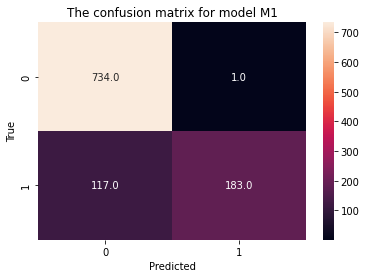

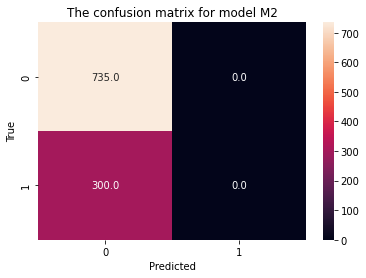

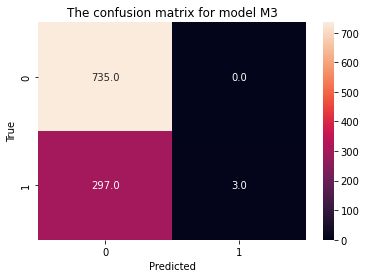

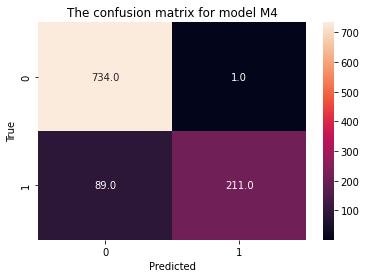

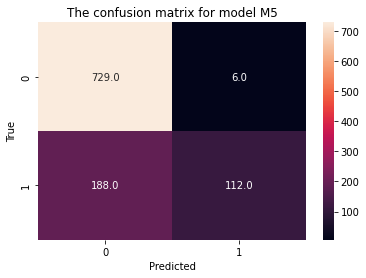

In [26]:
models = [M1,M2,M3,M4,M5]
names = ['M1','M2','M3','M4','M5']

for name,model in zip(names,models):
	# print(F'\n\nThe Confusion Matrix for model {name}\n')
	show_confu_matrix(name,model,val_tokenized)

# for name,model in zip(names,models):

# 	table = eval_model(model,val_tokenized)
# 	print(F'\n\nThe results for model {name}\n',table)


We also take a look at the confusion matrix of each model to validify results.

### b. Compare all 5 models [5 marks].


In [27]:
table = compare_all_models(models,names,val_tokenized)
print('The table below compares all the models using the validation dataset\n')
print(table)

The table below compares all the models using the validation dataset

+-------+--------------------+----------------------+--------------------+---------------------+
| Model |      Accuracy      |       F1 Score       |     Precision      |        Recall       |
+-------+--------------------+----------------------+--------------------+---------------------+
|   M1  | 0.8859903381642512 |  0.756198347107438   | 0.9945652173913043 |         0.61        |
|   M2  | 0.7101449275362319 |         0.0          |        0.0         |         0.0         |
|   M3  | 0.7130434782608696 | 0.019801980198019802 |        1.0         |         0.01        |
|   M4  | 0.9130434782608695 |      0.82421875      | 0.9952830188679245 |  0.7033333333333334 |
|   M5  |  0.81256038647343  |  0.5358851674641149  | 0.9491525423728814 | 0.37333333333333335 |
+-------+--------------------+----------------------+--------------------+---------------------+


As can be seen from the table above all the models have accuracies above 70%, however once we have taken a look at the F1, prediction and recall scores we realise that this accuracy is midleading. Models M2 and M3, do not perform well with regards to F1, prediction and recall scores. This is because when we only look at the 10 or 100 most frequent words some emails do not have any words when they are classified. When further analysis is peformed on these results,  a possible reason that models M2 and M3 do not perform well is because the train dataset is bias to non-spam examples(70% of the emails are not-spam while 30% are spam), thus when we only look at the 10 or 100 most frequent words of the vocabulary it is likely that these words came from the not-spam emails, leaving many of the spam emails without any words. 

### c. Make a recommendation about which model to use with reasons. [5 marks]


I would recommend the use of model M4 as it achieved the best results in every metric and would be able to generalise best out of all the models as it did not rely on the frequent words and achieved the highest recall score which is the most important metric here as it would not be that bad if a normal email got flagged as spam(the user would just verify this) but rather it would be a lot worse if spam email did not get flagged and went through undetected as a normal email and caused a lot of harm to the users computer.

## 5. Now, evaluate all the models with the test set


### a. Calculate the evaluation metrics [10 marks].

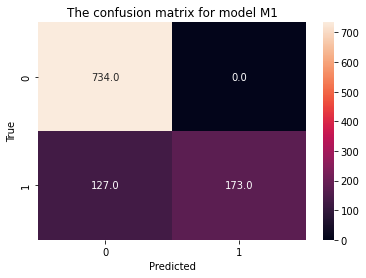

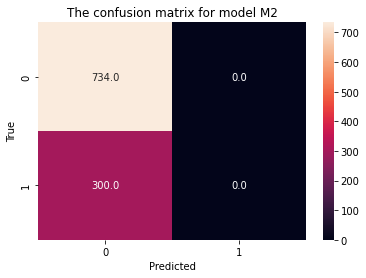

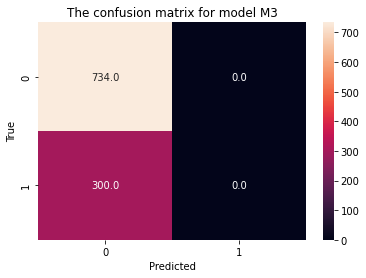

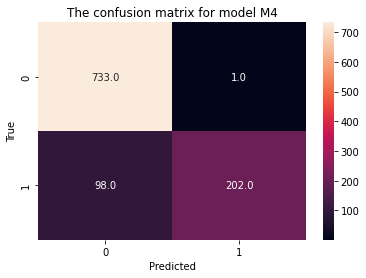

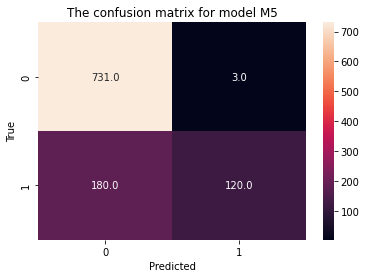

In [28]:
for name,model in zip(names,models):
	show_confu_matrix(name,model,test_tokenized)

In [29]:
table = compare_all_models(models,names,test_tokenized)
print('The table below compares all the models using the test dataset\n')
print(table)

The table below compares all the models using the test dataset

+-------+--------------------+--------------------+--------------------+--------------------+
| Model |      Accuracy      |      F1 Score      |     Precision      |       Recall       |
+-------+--------------------+--------------------+--------------------+--------------------+
|   M1  | 0.8771760154738878 | 0.7315010570824524 |        1.0         | 0.5766666666666667 |
|   M2  | 0.7098646034816247 |        0.0         |        0.0         |        0.0         |
|   M3  | 0.7098646034816247 |        0.0         |        0.0         |        0.0         |
|   M4  | 0.9042553191489362 | 0.8031809145129225 | 0.9950738916256158 | 0.6733333333333333 |
|   M5  | 0.8230174081237911 | 0.5673758865248227 | 0.975609756097561  |        0.4         |
+-------+--------------------+--------------------+--------------------+--------------------+


### b. Is your recommendation (in 4c above) still is valid? Explain [5 marks]

Yes the recommendation of model M4 is still valid as it still achieved the best result out of models M1 to M5 in all the metrics that we tested. However, the recall score has decreased and given the imporatnce of this metric it is vital that we increase it.

## 6. Implement at least one more variation to improve the performance of the best model. 
For instance, use frequent n-grams as features. The improvement should be on at least one of the evaluation metrics. Cleary describe the improved model and explain how it is an improvement. [5 marks]


#### To improve my model I focused on cutting down the feature space of the naive bayes architecture, while focusing on finding more meaningful features. I did this by finding the correlation between the indidivual words and the target label and only choosing the words which had a positive correlation with this label. By only choosing the words which had a positive correlation with the label, we were only choosing the words which had a direct relationship with the target variable and ignoring the words which were harming our predictions, thus meaningfully reducing the feature space.

First I had to convert our sentences into one-hot encoded vectors. I did this using sklearns MultiLabelBinarizer, now the columns have 1 if a word is present in that email, else 0.

In [78]:
mlb = sklearn.preprocessing.MultiLabelBinarizer()
train_mlb = pd.DataFrame(mlb.fit_transform([x for x in train_tokenized.text]),columns=mlb.classes_)

train_mlb['label'] = train_tokenized['label']

train_mlb.head()


,,,,,,,,0,00,000,...,zyjvit,zykfe,zyqtaqlt,zyrtec,zzezrjok,zzn,zzo,zzocb,zzso,zzsyt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


I calculate the correlation of these words with the target label.

In [36]:
correlations = train_mlb.corrwith(train_mlb['label'])

We only choose the positively correlated words.

In [73]:
corr_df = correlations.to_frame().rename_axis('Token').reset_index().rename(columns={0:'Corr'})
positive_corr_set = corr_df[corr_df['Corr'] > 0 ].Token.unique()

len(positive_corr_set)

26176

In [74]:
train_tokenized_improved = train_tokenized.copy()
train_tokenized_improved['text'] = train_tokenized_improved.text.apply(lambda x: [word for word in x if word in positive_corr_set])
M6 = Model(train_tokenized_improved)

### The new, improved M6 model has been built and now we can test it.

In [75]:
test_tokenized_pred =  test_tokenized.copy()
test_tokenized_pred['predicted_label'] = test_tokenized_pred.text.apply(lambda x: 1 if M6.predict_class(x)[0] > M6.predict_class(x)[1] else 0)

In [34]:
eval_model(M4,test_tokenized)


Metric,Value
Accuracy,0.9042553191489362
F1 Score,0.8031809145129225
Precision,0.9950738916256158
Recall,0.6733333333333333


In [76]:
eval_model(M6,test_tokenized)

Metric,Value
Accuracy,0.9274661508704062
F1 Score,0.8717948717948718
Precision,0.8947368421052632
Recall,0.85


Ac can be seen from the results above, the M6 model has improved performance in 3 out of the 4 evaluation metrics and most importantly has improved in recall, by almost 20%.